In [1]:
import tensorflow as tf
import numpy as np

In [2]:
import tensorflow as tf
import numpy as np
from keras import optimizers as opt
import matplotlib.pyplot as plt
from utils import load_data, augment_layer, preprocess_data
from spatial_transformer import create_spatial_transformer

In [3]:
data_dir = "C:/Users/chris/OneDrive - Syddansk Universitet/kandidat/3_semester\Maskinlæring/ds807_anvendt_maskinlæring/eksamen/exam/patch_camelyon"
BATCH_SIZE = 32
train, test, val = load_data(data_dir, perc=1, batch_size=BATCH_SIZE)


LEARNING_RATE = 0.001
OPTIMIZER = opt.Nadam(learning_rate = LEARNING_RATE)


def prep(x):
    return augment_layer(flip = "horizontal_and_vertical", rotation = 0.8, zoom = 0.6)(x)

x_train, y_train = preprocess_data(train, prep)



In [14]:

class Localization(tf.keras.layers.Layer):
    def __init__(self):
        super(Localization, self).__init__()
        self.pool1 = tf.keras.layers.MaxPool2D()
        self.conv1 = tf.keras.layers.Conv2D(20, [5, 5], activation='relu')
        self.pool2 = tf.keras.layers.MaxPool2D()
        self.conv2 = tf.keras.layers.Conv2D(20, [5, 5], activation='relu')
        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(20, activation='relu')
        self.fc2 = tf.keras.layers.Dense(6, activation=None, bias_initializer=tf.keras.initializers.constant([1.0, 0.0, 0.0, 0.0, 1.0, 0.0]), kernel_initializer='zeros')

    def build(self, input_shape):
        print("Building Localization Network with input shape:", input_shape)

    def compute_output_shape(self, input_shape):
        return [None, 6]

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        theta = self.fc2(x)
        theta = tf.keras.layers.Reshape((2, 3))(theta)
        return theta


class BilinearInterpolation(tf.keras.layers.Layer):
    def __init__(self, height=40, width=40):
        super(BilinearInterpolation, self).__init__()
        self.height = height
        self.width = width

    def compute_output_shape(self, input_shape):
        return [None, self.height, self.width, 1]

    def get_config(self):
        return {
            'height': self.height,
            'width': self.width,
        }
    
    def build(self, input_shape):
        print("Building Bilinear Interpolation Layer with input shape:", input_shape)

    def advance_indexing(self, inputs, x, y):
        '''
        Numpy like advance indexing is not supported in tensorflow, hence, this function is a hack around the same method
        '''        
        shape = tf.shape(inputs)
        batch_size, _, _ = shape[0], shape[1], shape[2]
        
        batch_idx = tf.range(0, batch_size)
        batch_idx = tf.reshape(batch_idx, (batch_size, 1, 1))
        b = tf.tile(batch_idx, (1, self.height, self.width))
        indices = tf.stack([b, y, x], 3)
        return tf.gather_nd(inputs, indices)

    def call(self, inputs):
        images, theta = inputs
        homogenous_coordinates = self.grid_generator(batch=tf.shape(images)[0])
        return self.interpolate(images, homogenous_coordinates, theta)

    def grid_generator(self, batch):
        x = tf.linspace(-1, 1, self.width)
        y = tf.linspace(-1, 1, self.height)
            
        xx, yy = tf.meshgrid(x, y)
        xx = tf.reshape(xx, (-1,))
        yy = tf.reshape(yy, (-1,))
        homogenous_coordinates = tf.stack([xx, yy, tf.ones_like(xx)])
        homogenous_coordinates = tf.expand_dims(homogenous_coordinates, axis=0)
        homogenous_coordinates = tf.tile(homogenous_coordinates, [batch, 1, 1])
        homogenous_coordinates = tf.cast(homogenous_coordinates, dtype=tf.float32)
        return homogenous_coordinates
    
    def interpolate(self, images, homogenous_coordinates, theta):

        with tf.name_scope("Transformation"):
            transformed = tf.matmul(theta, homogenous_coordinates)
            transformed = tf.transpose(transformed, perm=[0, 2, 1])
            transformed = tf.reshape(transformed, [-1, self.height, self.width, 2])
                
            x_transformed = transformed[:, :, :, 0]
            y_transformed = transformed[:, :, :, 1]
                
            x = ((x_transformed + 1.) * tf.cast(self.width, dtype=tf.float32)) * 0.5
            y = ((y_transformed + 1.) * tf.cast(self.height, dtype=tf.float32)) * 0.5

        with tf.name_scope("VariableCasting"):
            x0 = tf.cast(tf.math.floor(x), dtype=tf.int32)
            x1 = x0 + 1
            y0 = tf.cast(tf.math.floor(y), dtype=tf.int32)
            y1 = y0 + 1

            x0 = tf.clip_by_value(x0, 0, self.width-1)
            x1 = tf.clip_by_value(x1, 0, self.width-1)
            y0 = tf.clip_by_value(y0, 0, self.height-1)
            y1 = tf.clip_by_value(y1, 0, self.height-1)
            x = tf.clip_by_value(x, 0, tf.cast(self.width, dtype=tf.float32)-1.0)
            y = tf.clip_by_value(y, 0, tf.cast(self.height, dtype=tf.float32)-1)

        with tf.name_scope("AdvanceIndexing"):
            Ia = self.advance_indexing(images, x0, y0)
            Ib = self.advance_indexing(images, x0, y1)
            Ic = self.advance_indexing(images, x1, y0)
            Id = self.advance_indexing(images, x1, y1)

        with tf.name_scope("Interpolation"):
            x0 = tf.cast(x0, dtype=tf.float32)
            x1 = tf.cast(x1, dtype=tf.float32)
            y0 = tf.cast(y0, dtype=tf.float32)
            y1 = tf.cast(y1, dtype=tf.float32)
                            
            wa = (x1-x) * (y1-y)
            wb = (x1-x) * (y-y0)
            wc = (x-x0) * (y1-y)
            wd = (x-x0) * (y-y0)

            wa = tf.expand_dims(wa, axis=3)
            wb = tf.expand_dims(wb, axis=3)
            wc = tf.expand_dims(wc, axis=3)
            wd = tf.expand_dims(wd, axis=3)
                        
        return tf.math.add_n([wa*Ia + wb*Ib + wc*Ic + wd*Id])
    

def create_spatial_transformer(input_shape: tuple[int, int, int]) -> tf.keras.models.Model:
    """
    Creates a small spatial transformer network,
    It  returns a model which can be inserted into your current model
    
    Example
    -------
    >>> # Input Layer
    >>> input = tf.keras.layers.Input((96, 96, 3))
    
    >>> # Spatial Transformer Layer
    >>> spatial_transformer = create_spatial_transformer((96, 96, 3))(input)
    
    >>> # Convolutional Layer
    >>> x = tf.keras.layers.Conv2D(2, [9, 9], activation='relu')(spatial_transformer)
    >>> x = tf.keras.layers.Flatten()(x)
    >>> x = tf.keras.layers.Dense(2, activation='relu')(x)
    >>> x = tf.keras.layers.Dense(2, activation='softmax')(x)
    
    >>> # Initiate model
    >>> model = tf.keras.models.Model(inputs= input, outputs=x)
    """
    image = tf.keras.layers.Input(shape=input_shape)
    theta = Localization()(image)
    x = BilinearInterpolation(height=input_shape[0], width=input_shape[1])([image, theta])    
    model =  tf.keras.models.Model(inputs = image, outputs = x)

In [18]:
#spt = get_model((96, 96, 3))

# Input
image = tf.keras.layers.Input(shape=(96,96,3))
theta = Localization()(image)
bil_img = BilinearInterpolation(height=96, width=96)([image, theta])    
# Convolutional Layer
x = tf.keras.layers.Conv2D(2, [9, 9], activation='relu')(bil_img)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(2, activation='relu')(x)
x = tf.keras.layers.Dense(2, activation='softmax')(x)
model = tf.keras.models.Model(inputs= image, outputs=[bil_img, theta] )


model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])



Building Localization Network with input shape: (None, 96, 96, 3)
Building Bilinear Interpolation Layer with input shape: [TensorShape([None, 96, 96, 3]), TensorShape([None, 2, 3])]


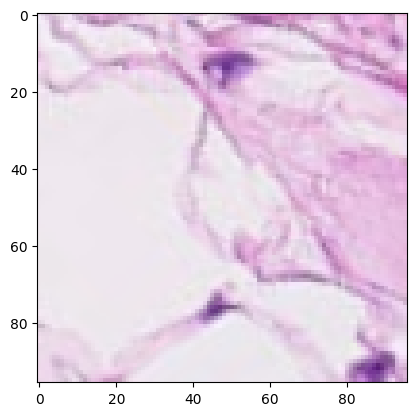

In [23]:
img = x_train[1]
plt.imshow(img)

In [20]:
theta, prediction = model.predict(train)

82/82 [==============================] - 18s 174ms/step


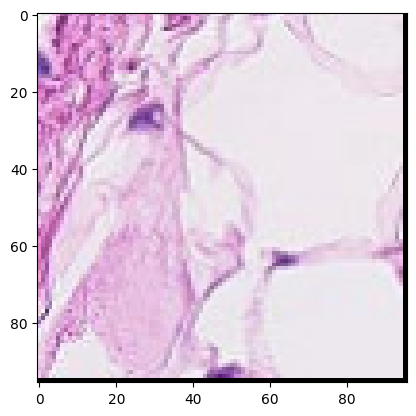

In [24]:
pred = theta[1]
plt.imshow(pred)


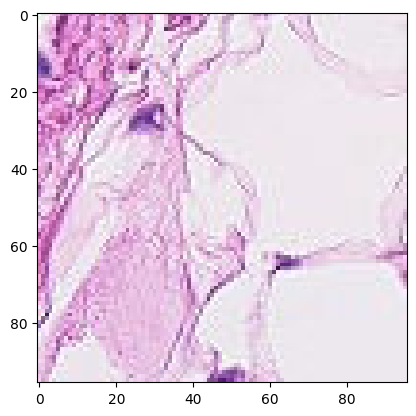

In [26]:
def prepper(x):
    return x
x_train_non, y_train = preprocess_data(train, prepper)

or_img = x_train_non[1]

plt.imshow(or_img)


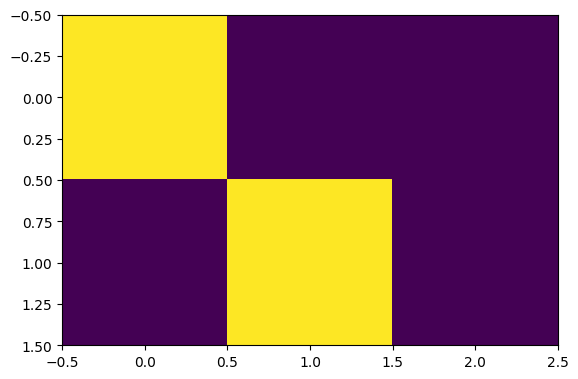

In [27]:
plt.imshow(prediction[0])